In [1]:
import os, time
import numpy as np
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
device = "cuda"

In [ ]:
from model.models import convNet, convNet_val

dig_model = convNet_val(in_channels=1)
dig_model.cuda()
dig_model.load_state_dict(torch.load("Kmnist_saved_model/Fold4_ep119_loss0.000_acc0.9922"))

model = convNet(in_channels=1)
model.cuda()
model.load_state_dict(torch.load("Kmnist_saved_model/ep70_acc0.9978"))


In [27]:
trans_dig = transforms.Compose([
        transforms.ToTensor(),  #Take Image as input and convert to tensor with value from 0 to1    
        transforms.Normalize(mean=[0.1126489],std=[0.28132638])  #dig_val distribution
    ])

trans = transforms.Compose([
        transforms.ColorJitter(0.5,0.2,0.2,0.5),
        transforms.RandomAffine(degrees=35,translate=(0.2,0.2),scale=[0.8,1.1],shear=15),
        transforms.ToTensor(),  #Take Image as input and convert to tensor with value from 0 to1    
#         transforms.Normalize(mean=[0.08194405],std=[0.238141])
    ])

global_data = pd.read_csv("./dataset/train.csv")
global_data_dig = pd.read_csv("./dataset/Dig-MNIST.csv")

class KMnistDataset(Dataset):
    def __init__(self,data_len=None, is_validate=False,validate_rate=None):
        self.is_validate = is_validate
        self.data = global_data_dig
#         self.data = global_data
        print("data shape:", np.shape(self.data))
        if data_len == None:
            data_len = len(self.data)
        
        if self.is_validate:
            self.len = int(data_len*validate_rate)
            self.offset = int(data_len*(1-validate_rate))
            self.transform = trans_dig
        else:
            self.len = int(data_len*(1-validate_rate))
            self.offset = 0
            self.transform = trans
        
    def __getitem__(self, idx):
        idx += self.offset
        img = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
        label = self.data.iloc[idx, 0]  #(num,)
        img = Image.fromarray(img)
        img = self.transform(img)     #value: 0~1, shape:(1,28,28)
        label = torch.as_tensor(label, dtype=torch.uint8)    #value: 0~9, shape(1)
        return img, label

    def __len__(self):
        return self.len

In [ ]:
dig_data = pd.read_csv("./dataset/Dig-MNIST-Augmented.csv")
for i in range(10,20):
    fig, axes = plt.subplots(1,2,figsize=(4,2))
    img2 = dig_data.iloc[i, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
    img2 = Image.fromarray(img2)
    label = dig_data.iloc[i, 0]
    axes[0].imshow(img2,cmap="gray")
#     img2 = trans(img2).cpu().numpy().reshape(28,28)
    axes[1].imshow(img2,cmap="gray")
    plt.pause(.1)
    print("Label:",label)

dig_data.head(5)
# type(dig_data.iloc[20,1:].values)  #numpy ndarray
# type(dig_data.iloc[20,0])  #numpy int64


# Diff between train_set and Dig_val set

In [ ]:
vr = 1
dataset = KMnistDataset(data_len=None,is_validate=True, validate_rate=vr)
loader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=0)

result = np.array([])
result_dig = np.array([])
labels = np.array([])
data_num = 0

for idx,data in enumerate(loader):
    img, label = data
    img, label = img.to(device), label.to(device)
    _,pred = torch.max(model(img),dim=1)
    _,pred_dig = torch.max(dig_model(img),dim=1)
    result = np.concatenate([result,pred.cpu().numpy()],axis=0)
    result_dig = np.concatenate([result_dig,pred_dig.cpu().numpy()],axis=0)
    labels = np.concatenate([labels,label.cpu().numpy()],axis=0)
    data_num += img.size(0)

print("finished:",data_num)
print(np.shape(result),np.shape(result_dig),np.shape(labels))
  

indices1 = np.where(result!=labels)[0]       #(num)
indices2 = np.where(result_dig!=labels)[0]
indices3 = np.where((result!=labels)&(result_dig==labels))[0]

print(len(indices1),len(indices2),len(indices3))  #dig: 912 51 878
#up: 954
for i in range(40,50):
    idx = indices2[i]
    fig, axes = plt.subplots(1,1,figsize=(2,2))
    img1 = global_data_dig.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255

    img1 = Image.fromarray(img1)
    label1 = result[idx]
    label2 = result_dig[idx]
    label = labels[idx]
#     label = global_data.iloc[idx, 0]  #(num,)
    axes.imshow(img1,cmap="gray")
    plt.pause(.1)
    print("Model:",label1," Model2:",label2," Label:",label)


# Augment dig dataset

In [45]:
vr = 0
batch_size = 1024
dataset = KMnistDataset(data_len=None,is_validate=False, validate_rate=vr)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
num_per_class = 6000  # 6000 * 10 =60000

pix_str = "pixel0"
for i in range(1,784):
    pix_str = pix_str + ",pixel" + str(i)
numpy_header = "label," + pix_str

dig_data = pd.read_csv("./dataset/Dig-MNIST.csv")
# dig_data.head(5)


data shape: (10240, 785)


In [47]:
aug_list = np.empty((0,785))
counter_list = np.zeros((10,)).astype(int)

###Load original 10240 data
origin_img = dig_data.iloc[:, 1:].values.astype(np.uint8).reshape((-1,784))  #value: 0~255
origin_label = np.array(dig_data.iloc[:,0]).astype(int)

for i in range(len(origin_img)):
    if i%1000==0:
        print(i)
    tmp_img = origin_img[i]    #(784,)
    tmp_label = origin_label[i].reshape(-1) #(1,)
    csv_arr = np.concatenate([tmp_label,tmp_img])   #(785,)
    aug_list = np.vstack((aug_list,csv_arr))
    counter_list[tmp_label] += 1

print("shape of aug_list:",np.shape(aug_list))
print("counter_list:",counter_list)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
shape of aug_list: (10240, 785)
counter_list: [1024 1024 1024 1024 1024 1024 1024 1024 1024 1024]


In [48]:
###Augment data by random select and affine
keep_loop = True
while keep_loop:
    for idx,data in enumerate(loader):
        img, label = data
        img, label = img.to(device), label.to(device)

        img = img.cpu().numpy()
        img = np.uint8(img*255).reshape(batch_size,-1)
        label = label.cpu().numpy()
        
        for i in range(batch_size):
            tmp_img = img[i]    #(784,)
            tmp_label = label[i].reshape(-1) #(1,)
            if counter_list[tmp_label] >= num_per_class:
                continue
#             print(np.shape(tmp_label),np.shape(tmp_img))
            csv_arr = np.concatenate([tmp_label,tmp_img])   #(785,)
#             print("csv arr shape:",np.shape(csv_arr))
            
            aug_list = np.vstack((aug_list,csv_arr))
#             print("aug_list shape:",np.shape(aug_list))
            counter_list[tmp_label] += 1

        print("shape of aug_list:",np.shape(aug_list))
        print("counter_list:",counter_list)
        if (counter_list>=num_per_class).all() == True:
            print("Augment Finished")
            print(np.shape(aug_list))
            print(counter_list)
            np.savetxt("./dataset/Dig-Mnist-Augmented.csv", aug_list, delimiter=",",fmt="%d",header=numpy_header,comments='')
            keep_loop = False
            break

shape of aug_list: (11264, 785)
counter_list: [1135 1137 1121 1131 1123 1137 1119 1121 1124 1116]
shape of aug_list: (12288, 785)
counter_list: [1229 1245 1233 1247 1228 1234 1225 1203 1226 1218]
shape of aug_list: (13312, 785)
counter_list: [1318 1331 1358 1356 1326 1323 1343 1305 1334 1318]
shape of aug_list: (14336, 785)
counter_list: [1420 1433 1449 1464 1422 1438 1450 1408 1445 1407]
shape of aug_list: (15360, 785)
counter_list: [1523 1529 1562 1561 1534 1542 1545 1492 1557 1515]
shape of aug_list: (16384, 785)
counter_list: [1625 1629 1661 1653 1639 1639 1667 1611 1650 1610]
shape of aug_list: (17408, 785)
counter_list: [1730 1734 1770 1765 1733 1739 1756 1703 1763 1715]
shape of aug_list: (18432, 785)
counter_list: [1838 1828 1868 1859 1853 1851 1852 1814 1840 1829]
shape of aug_list: (19456, 785)
counter_list: [1943 1933 1956 1954 1948 1958 1945 1932 1937 1950]
shape of aug_list: (20480, 785)
counter_list: [2048 2048 2048 2048 2048 2048 2048 2048 2048 2048]
shape of aug_list: (

# Show data distribution

(60000,)


Text(0, 0.5, 'frequency')

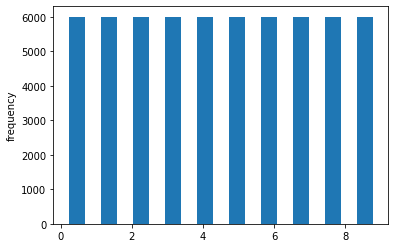

In [49]:
# data = np.random.random([1000,])
dig_data = pd.read_csv("./dataset/Dig-MNIST-Augmented.csv")
# dig_data = pd.read_csv("./dataset/train.csv")
dig_data = dig_data.iloc[:,0]
print(np.shape(dig_data))

plt.hist(dig_data ,density=0,bins=10,label=True,rwidth=0.5)
# plt.hist(img[100].reshape(-1) ,density=1,bins=10,range=(0.2,1),label=True)
# print((label==5).sum().item())
plt.ylabel('frequency')

In [ ]:
plt.hist(data ,density=1,bins=10,label=True,rwidth=0.6)
plt.ylabel('frequency')